https://github.com/rom1504/img2dataset 大规模图文数据集读取。

In [ ]:
# 以COCO为例
import os 
root_dir = '/home/chenweifeng/dataset/mm_data/COCO/mscoco_dataset/images'

# Pyarrow

In [ ]:
import pyarrow.parquet as pq
pq_files = [os.path.join(root_dir, f) for f in  os.listdir(root_dir) if f.endswith('.parquet')]
print(pq_files)

In [ ]:
tables = []
for pq_file in pq_files:
    table = pq.read_table(pq_file)
    tables.append(table)

In [ ]:
print(tables[0].column_names)
print(tables[0]['caption'])
print(tables[0])

# Webdataset


In [ ]:
import torch
from torch.utils.data import IterableDataset
from torchvision import transforms
import webdataset as wds
from itertools import islice

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# url = "/home/chenweifeng/dataset/mm_data/COCO/mscoco_dataset/images/{00000..00056}.tar"
url = "/home/chenweifeng/dataset/mm_data/COCO/mscoco_dataset/images/{00000..00056}.tar"


dataset = wds.WebDataset(url)
for sample in islice(dataset, 0, 2):
    for key, value in sample.items():
        print(key, repr(value)[:50])
    print()
dataset = (
    wds.WebDataset(url)
    .shuffle(1000)
    .decode("rgb")
    .to_tuple("jpg;png", "json")
)

# len(dataset)
for image, data in islice(dataset, 0, 1):
    print(image.shape, image.dtype, type(data), data)

In [ ]:
batch_size = 2048
dataloader = torch.utils.data.DataLoader(dataset.batched(batch_size), num_workers=4, batch_size=None)
# images, targets = next(iter(dataloader))
# images.shape
# targets

In [ ]:
total = 0
for images, targets in dataloader:
    total += len(images)
#     print(total)
# print(total)

In [ ]:
for i, data in enumerate(dataloader):
    print(data)
    if i == 10:
        break

# zero 数据集读取dataset

In [ ]:
import torch
from torch.utils.data import IterableDataset
from torchvision import transforms
import webdataset as wds
from itertools import islice
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# url = "/home/chenweifeng/dataset/mm_data/COCO/mscoco_dataset/images/{00000..00056}.tar"
url = "/home/chenweifeng/dataset/mm_data/zero23m/images/{00000..02343}.tar"
dataset = wds.WebDataset(url)
print(dataset)
for sample in islice(dataset, 0, 2):
    for key, value in sample.items():
        print(key, repr(value)[:50])
    print()
dataset = (
    wds.WebDataset(url)
    .shuffle(1000)
    .decode("rgb")
    .to_tuple("jpg;png", "json")
)

# print(dataset)
# # # print(len(dataset))
# total = 0
# # for image, data in islice(dataset, 0, 5):
# for image, data in dataset:
#     # print(image.shape, data['caption'])
#     total += 1
# print(total)

In [ ]:
from torch.utils.data import IterableDataset, DataLoader
import math
class MyIterableDataset(IterableDataset):
    def __init__(self, start, end):
        super(MyIterableDataset).__init__()
        assert end > start, "this example code only works with end >= start"
        self.start = start
        self.end = end
    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = self.start
            iter_end = self.end
        else:  # in a worker process
            # split workload
            per_worker = int(math.ceil((self.end - self.start) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = self.start + worker_id * per_worker
            iter_end = min(iter_start + per_worker, self.end)
        return iter(range(iter_start, iter_end))
# should give same set of data as range(3, 7), i.e., [3, 4, 5, 6].
ds = MyIterableDataset(start=3, end=7)

# Single-process loading
print(list(DataLoader(ds, num_workers=0)))
# Mult-process loading with two worker processes
# Worker 0 fetched [3, 4].  Worker 1 fetched [5, 6].
print(list(DataLoader(ds, num_workers=2)))
# With even more workers
print(list(DataLoader(ds, num_workers=20)))


In [ ]:
import braceexpand
import os
import json

def get_dataset_len(json_url):
    shards_list = list(braceexpand.braceexpand(json_url))
    total = 0
    for shard in shards_list:
        with open(shard) as f:
            data = json.load(f)
            # print(data)
            total += data['successes']
    return total

def get_dataset_size(shards):
    shards_list = list(braceexpand.braceexpand(shards))
    dir_path = os.path.dirname(shards)
    print(dir_path, shards_list)
    sizes_filename = os.path.join(dir_path, 'sizes.json')
    len_filename = os.path.join(dir_path, '__len__')
    if os.path.exists(sizes_filename):
        sizes = json.load(open(sizes_filename, 'r'))
        total_size = sum([int(sizes[os.path.basename(shard)]) for shard in shards_list])
    elif os.path.exists(len_filename):
        # FIXME this used to be eval(open(...)) but that seemed rather unsafe
        total_size = ast.literal_eval(open(len_filename, 'r').read())
    else:
        json_url = "/home/chenweifeng/dataset/mm_data/zero23m/images/{00000..02343}_stats.json"
        total_size = get_dataset_len(json_url)
        # print(total_num)
        # total_size = None  # num samples undefined
        # some common dataset sizes (at time of authors last download)
        # cc3m-train: 2905954
        # cc12m: 10968539
        # LAION-400m: 407332084
    num_shards = len(shards_list)
    return total_size, num_shards

In [ ]:
total_size, num_shards = get_dataset_size(url)
# json_url = "/home/chenweifeng/dataset/mm_data/zero23m/images/{00000..02343}_stats.json"
# total_num = get_dataset_len(json_url)
# print(total_num)

In [ ]:
print(total_size, num_shards)

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
class flickr30k_CNA(Dataset):
    def __init__(self, img_root_path='/home/chenweifeng/dataset/mm_data/Flickr30k-CNA/flickr30k/images', \
                text_annot_path='/home/chenweifeng/dataset/mm_data/Flickr30k-CNA/test/flickr30k_cn_test.txt', \
                transform=None):
        self.images = []
        self.captions = []
        self.labels = []
        self.root = img_root_path
        with open(text_annot_path, 'r') as f:
            for line in f:
                line = line.strip().split('\t')
                key, caption = line[0].split('#')[0], line[1]
                img_path = key + '.jpg'
                self.images.append(img_path)
                self.captions.append(caption)
                self.labels.append(key)
        self.transforms = transform
        self.tokenizer = BertTokenizer.from_pretrained("hfl/chinese-roberta-wwm-ext")

        # NOTE large 模型
        self.context_length = 77

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = str(self.images[idx])
        image = self.transforms(Image.open( os.path.join(self.root, img_path ))) 
        text = self.tokenizer(str(self.captions[idx]), max_length=self.context_length, padding='max_length', truncation=True, return_tensors='pt')['input_ids'][0]
        label = self.labels[idx]
        return image, text, label

# directly read tar file

In [ ]:
import tarfile
import braceexpand
url = "/home/chenweifeng/dataset/mm_data/zero23m/images/{00000..02343}.tar"

images_path = []
captions_path = []
for each_tar in list(braceexpand.braceexpand(url)):
    print(each_tar)
    with tarfile.open(each_tar, "r") as tar:
        for each_file in tar.getmembers():
            # print(each_file.name)
            if each_file.name.endswith(".jpg"):
                images_path.append(each_file.name) 
            elif each_file.name.endswith(".txt"):
                captions_path.append(each_file.name) 
        break

In [ ]:
print(len(images_path), len(captions_path))

In [ ]:
from PIL import TarIO,Image

fp = TarIO.TarIO('/home/chenweifeng/dataset/mm_data/zero23m/images/00000.tar', images_path[0])
im = Image.open(fp)

In [4]:
# preprocess laion-zh
import tarfile
import braceexpand
from glob import glob
import os
url = '/shared_space/ccnl/mm_data/laion2B-multi-chinese-subset/*/'
images_path = []
captions_path = []
all_files = glob(os.path.join(url, '*.tar'))
# print(len(all_files))
for each_tar in all_files:
    # print(each_tar)
    with tarfile.open(each_tar, "r") as tar:
        for each_file in tar.getmembers():
            # print(each_file.name)
            if each_file.name.endswith(".jpg"):
                images_path.append( [each_tar, each_file.name] ) 
            elif each_file.name.endswith(".txt"):
                captions_path.append( [each_tar, each_file.name] ) 
        break
print(len(images_path), len(captions_path))


8900 8900


TypeError: __init__() missing 1 required positional argument: 'file'

In [7]:
from PIL import Image, TarIO
print(images_path[0])
fp = TarIO.TarIO(*images_path[0])
im = Image.open(fp)


['/shared_space/ccnl/mm_data/laion2B-multi-chinese-subset/image_part06/00639.tar', '006390005.jpg']


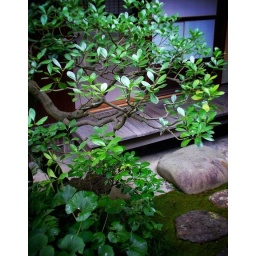

In [9]:
im

In [8]:
captions_path[0]

'006390005.txt'

In [ ]:
images_path[0]

In [ ]:
import shutil
for img, txt in zip(image_paths, captions_paths):
    shutil.copy(img, '/shared_space/ccnl/mm_data/laion2B-multi-chinese-subset/images')
    shutil.copy(txt, '/shared_space/ccnl/mm_data/laion2B-multi-chinese-subset/captions')

In [ ]:
import tarfile
import glob, os
import numpy as np
from PIL import Image, TarIO
from tqdm import tqdm
import json

path = '/shared_space/ccnl/mm_data/zero_sub/images/'
tar_list = glob.glob(path + '*.tar')
tar_list.sort()
print('length of tar:', len(tar_list))
print(tar_list[0])

#读取文件名，并放到list中
tar = tarfile.open(tar_list[0], "r")
file_list = []
for i in tar:
    file_list.append(i.name)
file_list.sort()
print(len(file_list), file_list[3:6])
# ['000000000.jpg', '000000000.json', '000000000.txt']

#利用Image类读入图片
fp = TarIO.TarIO(tar_list[0], file_list[3])
im = Image.open(fp)
im.save('./temp/' + file_list[0])

#从Image类转化为numpy array
# arr_im = np.asarray(im)
# print(arr_im)

temp_json =  tar.extractfile(file_list[4])
temp_json = json.loads(temp_json.read())
print(temp_json)

temp_txt =  tar.extractfile(file_list[5])
temp_txt = temp_txt.read()
print(temp_txt.decode('utf8'))